# NONCOVToolbox: Step 4

## Dataset preparation and Machine Learning

### Load necessary modules from the NONCOVToolbox src

In [63]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

In [65]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

Current work directory is: /Users/ettorebartalucci/Desktop/NONCOV/results
Current scratch directory is: /Users/ettorebartalucci/Desktop/NONCOV/scratch
Normalized path using os.path: /Users/ettorebartalucci/Desktop/NONCOV/scratch


In [67]:
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

dataset_name = 'fragments_hopt_nmr.csv'

nucprop = os.path.join(datasets_dir, dataset_name)
nucprop_df = pd.read_csv(nucprop)

Dataset directory is: /Users/ettorebartalucci/Desktop/NONCOV/scratch/GenerateMLDataset/data/
Normalized path using os.path: /Users/ettorebartalucci/Desktop/NONCOV/scratch/GenerateMLDataset/data/


### Explorative Data Analysis

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers
import sklearn.manifold, sklearn.cluster

In [41]:
nucprop_df = nucprop_df.drop(columns='s_tot_symmetry')


nucprop_df.head()

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,span,skew
0,df_cut_4_n1_opt.xyz,Nucleus 7H :,1.004732,0.618235,0.399603,28.71,34.44,26.20,25.50,45.09,24.36,20.37,-12.17,3.32,5.17,25.50,26.20,34.44,8.94,-0.84
1,df_cut_4_n1_opt.xyz,Nucleus 8H :,-0.479139,0.823720,0.426466,28.66,33.20,27.90,24.88,24.68,36.46,34.50,-8.86,-2.88,2.09,24.88,27.90,33.20,8.32,-0.27
2,df_cut_4_n1_opt.xyz,Nucleus 9H :,-1.139424,1.293590,-0.715278,25.80,29.45,26.15,21.81,45.32,29.24,30.01,-19.56,0.18,-7.79,21.81,26.15,29.45,7.64,0.14
3,df_cut_4_n1_opt.xyz,Nucleus 10H :,-2.529680,1.410024,-0.731269,25.71,21.87,27.98,27.28,45.53,32.43,18.25,-18.92,-4.64,4.48,21.87,27.28,27.98,6.11,0.77
4,df_cut_4_n1_opt.xyz,Nucleus 11H :,-3.272787,1.055261,0.391918,23.23,22.20,23.28,24.21,12.13,42.96,40.98,10.96,-20.55,-16.79,22.20,23.28,24.21,2.01,0.07


In [19]:
nucprop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14366 entries, 0 to 14365
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Molecule       14366 non-null  object 
 1   Atom           14366 non-null  object 
 2   x_coord        14366 non-null  float64
 3   y_coord        14366 non-null  float64
 4   z_coord        14366 non-null  float64
 5   sigma_iso      14366 non-null  float64
 6   sigma_xx       14366 non-null  float64
 7   sigma_yy       14366 non-null  float64
 8   sigma_zz       14366 non-null  float64
 9   dia_sigma_xx   14366 non-null  float64
 10  dia_sigma_yy   14366 non-null  float64
 11  dia_sigma_zz   14366 non-null  float64
 12  para_sigma_xx  14366 non-null  float64
 13  para_sigma_yy  14366 non-null  float64
 14  para_sigma_zz  14366 non-null  float64
 15  sigma_11       14366 non-null  float64
 16  sigma_22       14366 non-null  float64
 17  sigma_33       14366 non-null  float64
 18  span  

In [60]:
nucprop_df[['sigma_iso','sigma_xx','sigma_yy','sigma_zz','span','skew']].describe().applymap(lambda x: f"{x:0.1f}")

/var/folders/s_/t420f2pn6xq2bv06qkv7bdp40000gn/T/ipykernel_41099/2113098127.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nucprop_df[['sigma_iso','sigma_xx','sigma_yy','sigma_zz','span','skew']].describe().applymap(lambda x: f"{x:0.1f}")


,sigma_iso,sigma_xx,sigma_yy,sigma_zz,span,skew
count,14366.0,14366.0,14366.0,14366.0,14366.0,14366.0
mean,62.8,76.3,56.8,55.4,98.8,-0.2
std,78.3,117.7,88.5,97.4,122.6,0.4
min,-294.7,-726.1,-310.8,-422.9,2.0,-1.0
25%,26.6,23.9,23.7,21.0,10.6,-0.5
50%,29.6,35.2,27.6,27.0,48.8,-0.2
75%,62.2,148.2,76.3,94.3,162.6,0.1
max,382.5,467.7,359.3,361.9,782.5,0.9


In [50]:
sns.distplot(nucprop_df.sigma_iso)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.distplot(ax=axes[0, 0], nucprop_df.sigma_iso)
sns.distplot(ax=axes[0, 1], nucprop_df.sigma_xx)
sns.distplot(ax=axes[1, 0], nucprop_df.sigma_xx)
sns.distplot(ax=axes[1, 1], nucprop_df.sigma_xx)


SyntaxError: positional argument follows keyword argument (3635500553.py, line 5)

In [45]:
# get 3 lowest and 3 highest shifts
nucprop_df_sorted = nucprop_df.sort_values("sigma_iso")
extremes = pd.concat([nucprop_df_sorted[:3], nucprop_df_sorted[-3:]])
extremes

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,span,skew
3823,dy_cut_4_n1_opt.xyz,Nucleus 19O :,-3.425522,-3.322821,-0.792752,-294.67,-726.09,-167.47,9.54,441.50,402.13,424.23,-1164.21,-572.96,-414.71,-726.09,-167.47,9.54,735.63,0.52
3846,dy_cut_4_n1_opt_disp_struct_0.xyz,Nucleus 19O :,-3.478610,-3.556009,-0.865586,-223.14,-560.04,-177.18,67.81,401.52,434.28,424.90,-986.93,-586.12,-357.08,-560.04,-177.18,67.81,627.85,0.22
21,df_cut_4_n1_opt.xyz,Nucleus 18O :,-2.210609,-2.779859,-2.095317,-205.60,-647.23,-52.74,83.17,449.21,390.79,412.57,-1092.88,-447.46,-329.03,-647.23,-52.74,83.17,730.40,0.63
2125,dw_cut_4_n1_4f_opt.xyz,Nucleus 16F :,2.435687,-4.000801,3.348517,379.95,458.22,357.64,323.99,460.47,472.92,483.75,-9.80,-107.92,-159.56,323.99,357.64,458.22,134.23,-0.50
2123,dw_cut_4_n1_4f_opt.xyz,Nucleus 12F :,1.707587,-4.813178,1.967342,380.92,461.92,318.92,361.93,483.01,466.87,459.40,-2.47,-163.72,-100.32,318.92,361.93,461.92,143.00,-0.40
1579,dw_cut_4_n1_3f_opt.xyz,Nucleus 16F :,2.316910,-4.129219,3.354491,382.54,467.71,354.75,325.16,486.99,468.90,454.66,9.55,-110.92,-161.56,325.16,354.75,467.71,142.55,-0.58


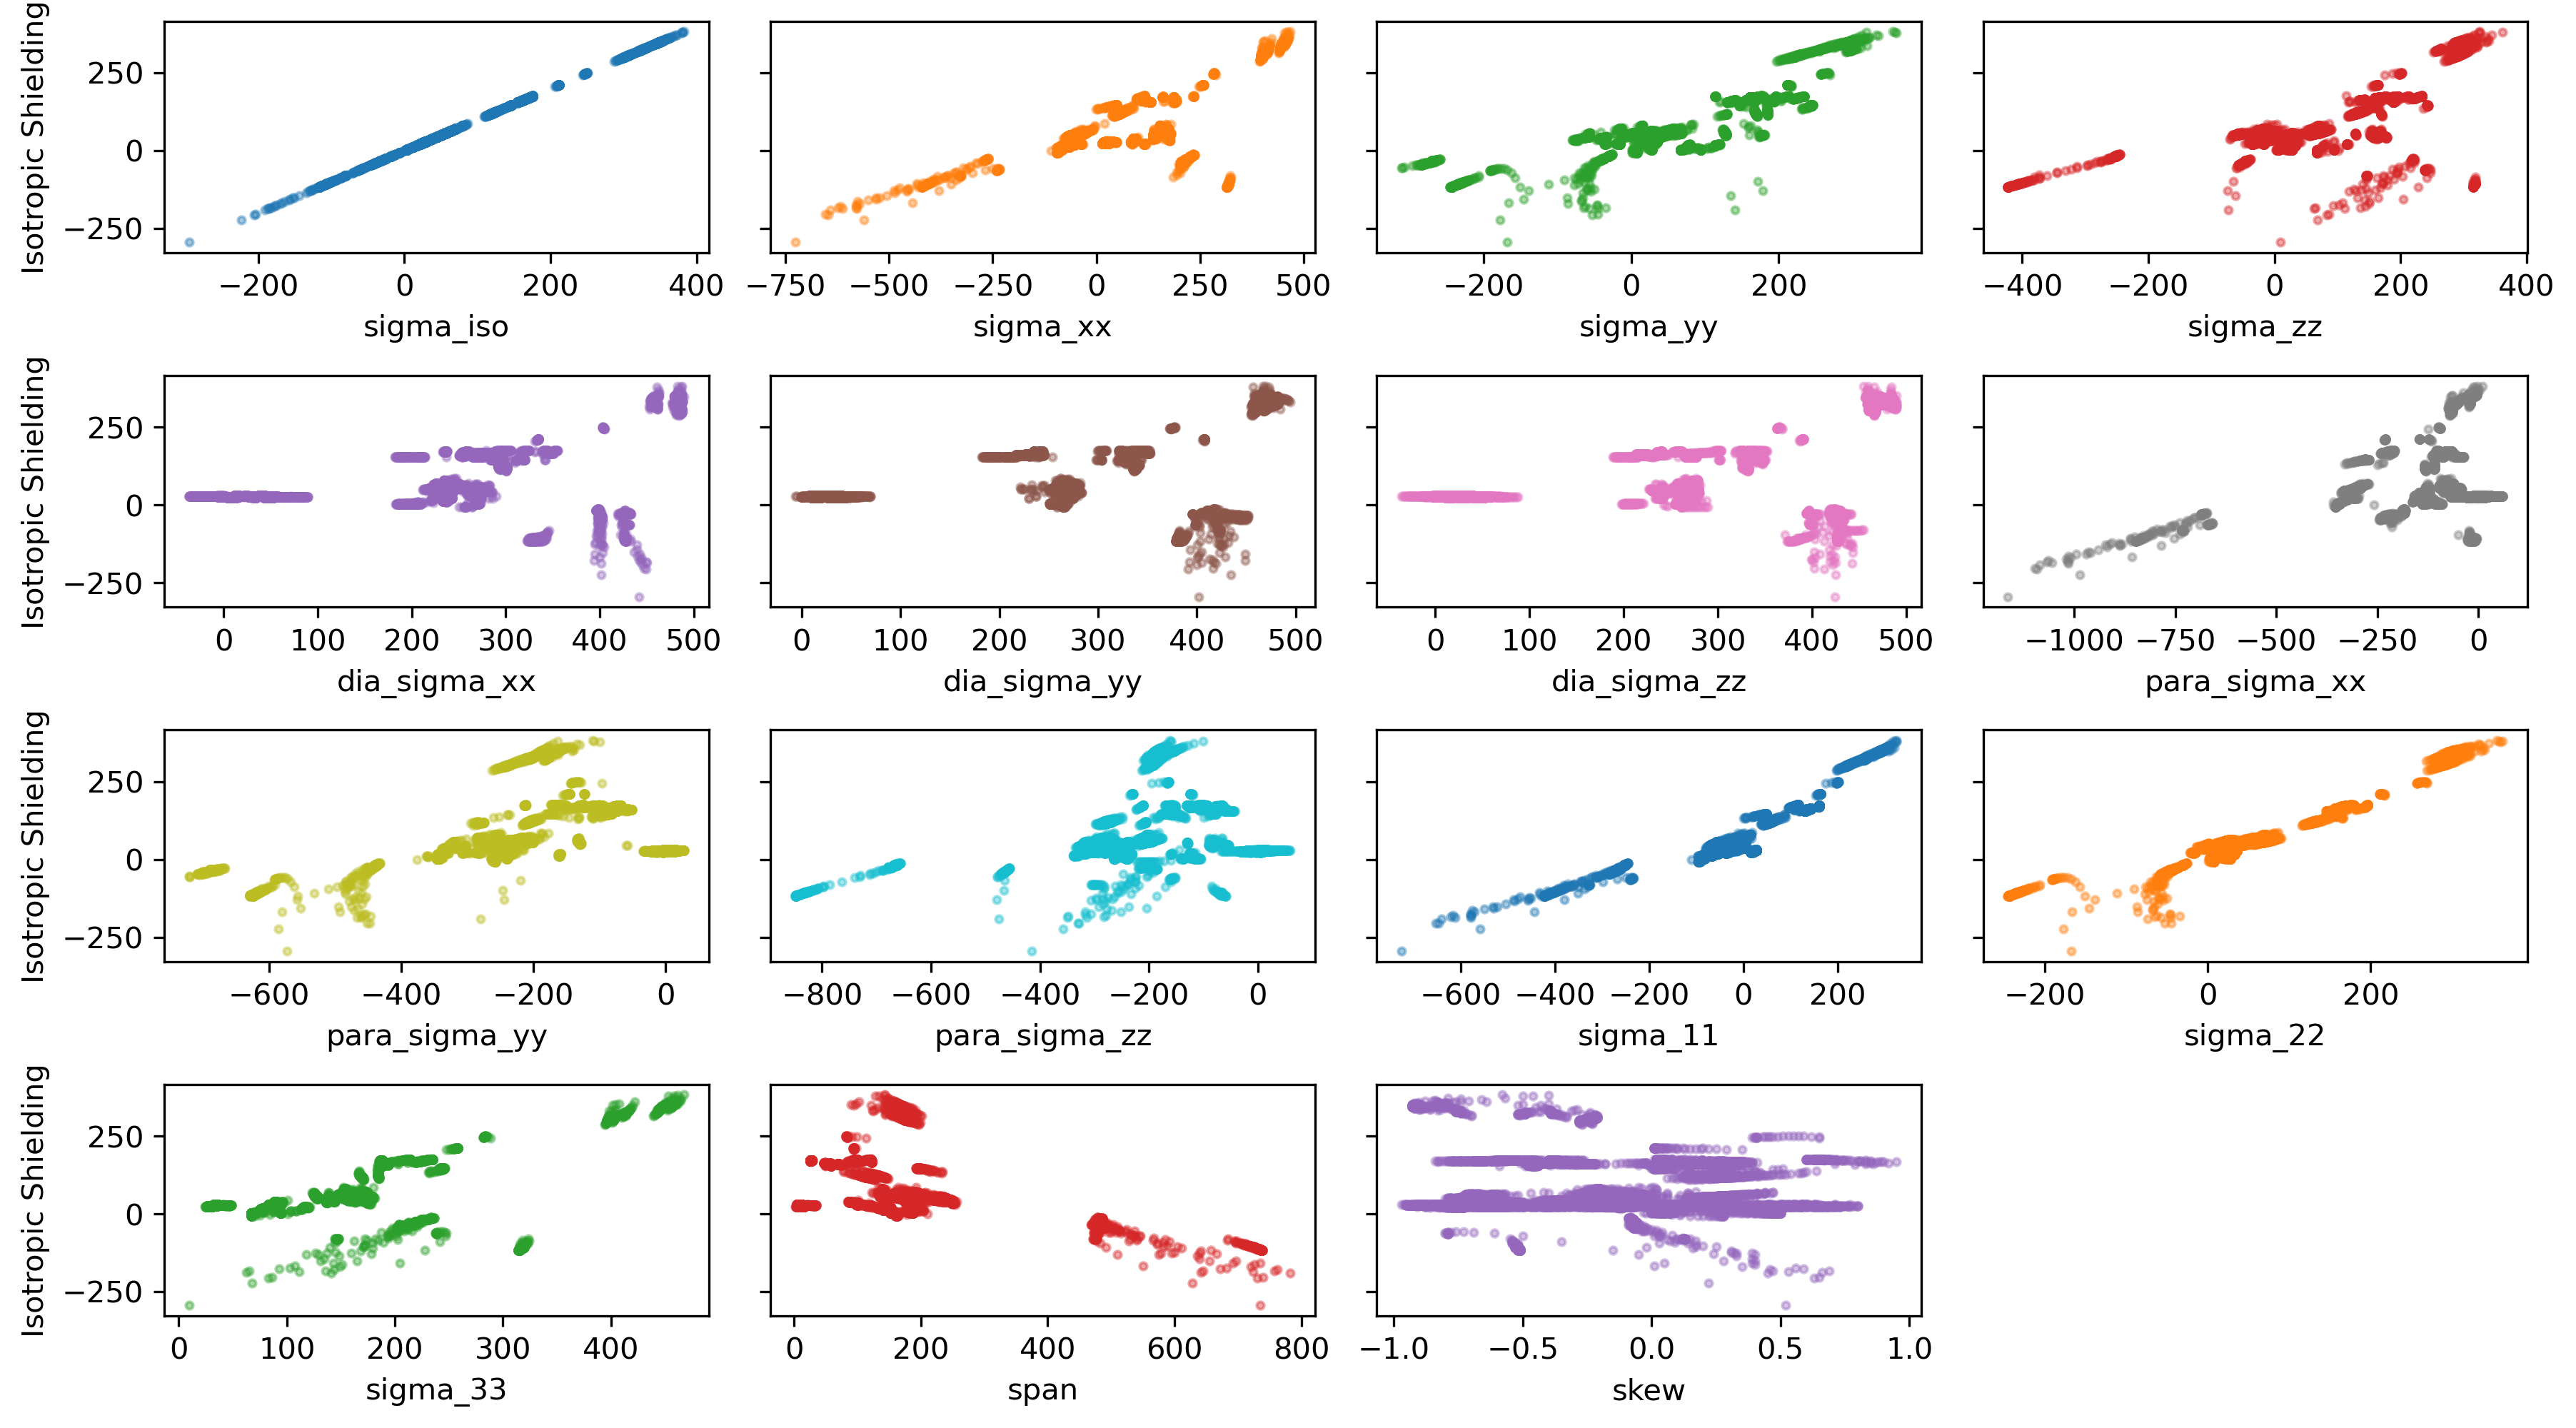

In [47]:
features_start_at = list(nucprop_df.columns).index("sigma_iso")
feature_names = nucprop_df.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        nucprop_df[n], nucprop_df.sigma_iso, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Isotropic Shielding")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

## Unsupervised Learning

#### Clustering

In [51]:
# convert data into features, labels
features = nucprop_df.loc[:, feature_names].values
labels = nucprop_df.sigma_iso.values
# standardize features
fstd = np.std(features, axis=0)
fmean = np.mean(features, axis=0)
std_features = (features - fmean) / fstd

array([[-0.43578504, -0.3557115 , -0.34607091, ..., -0.81133795,
        -0.73270381, -1.73382255],
       [-0.43642337, -0.36625068, -0.32686982, ..., -0.82376785,
        -0.73776025, -0.22650563],
       [-0.47293624, -0.3981232 , -0.34663564, ..., -0.8613583 ,
        -0.74330602,  0.85770479],
       ...,
       [ 0.02190242, -0.83677402,  0.04608309, ...,  0.39626779,
         0.63848781,  0.32882166],
       [-0.21428218, -1.16204367, -0.14140989, ...,  0.39015307,
         0.94562559,  0.43459828],
       [ 1.88073904,  1.5231521 ,  1.80580639, ...,  1.40459402,
        -0.01265083,  1.01636973]])

In [53]:
# get down to 2 dimensions for easy visuals
embedding = sklearn.manifold.Isomap(n_components=2)
# only fit to every 25th point to make it fast
embedding.fit(std_features[::25, :])
reduced_features = embedding.transform(std_features)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 19 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/anaconda3/lib/pyt

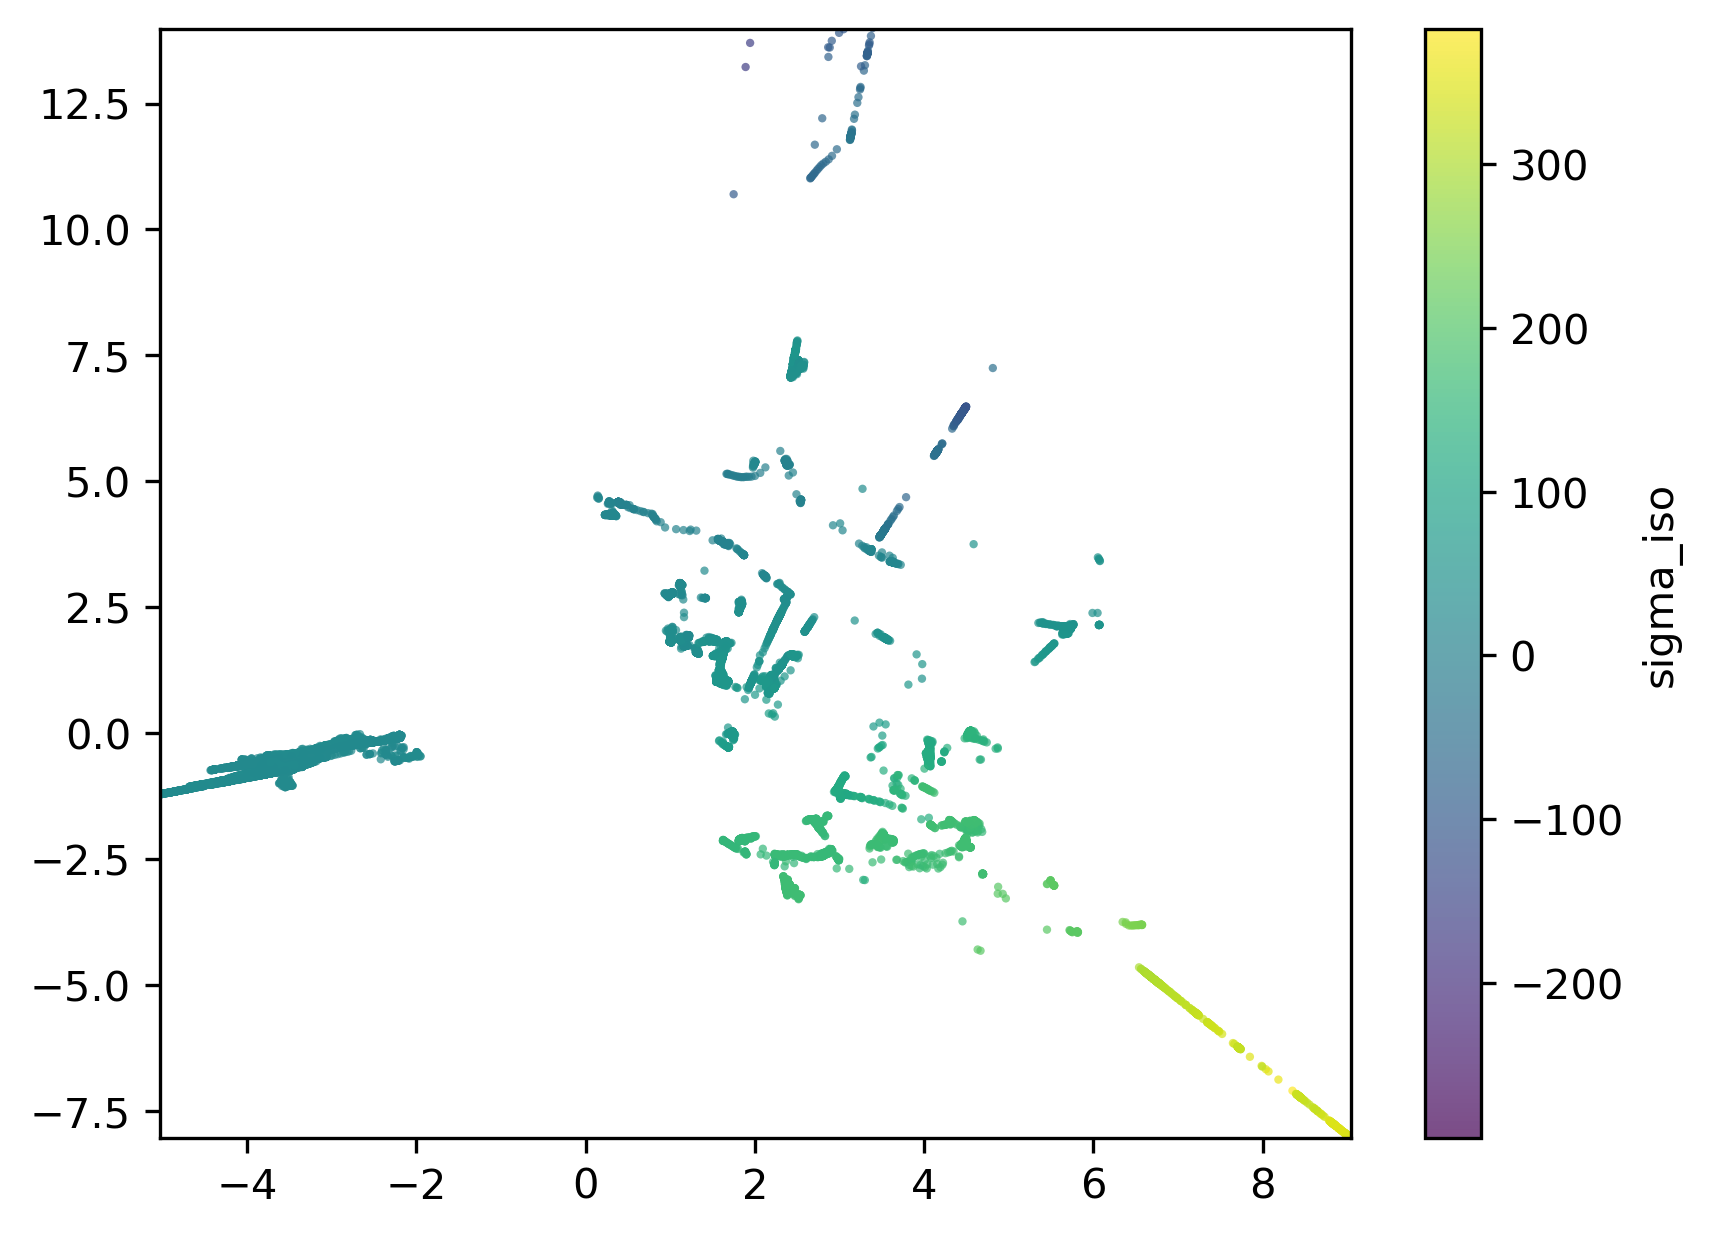

In [57]:
xlow, xhi = np.quantile(reduced_features, [0.005, 0.995], axis=0)

plt.figure(dpi=300)
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=labels,
    edgecolors="none",
)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
cb = plt.colorbar()
cb.set_label("sigma_iso")
plt.show()

In [59]:
# cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=5, random_state=0)
kmeans.fit(std_features)

KMeans(n_clusters=5, random_state=0)

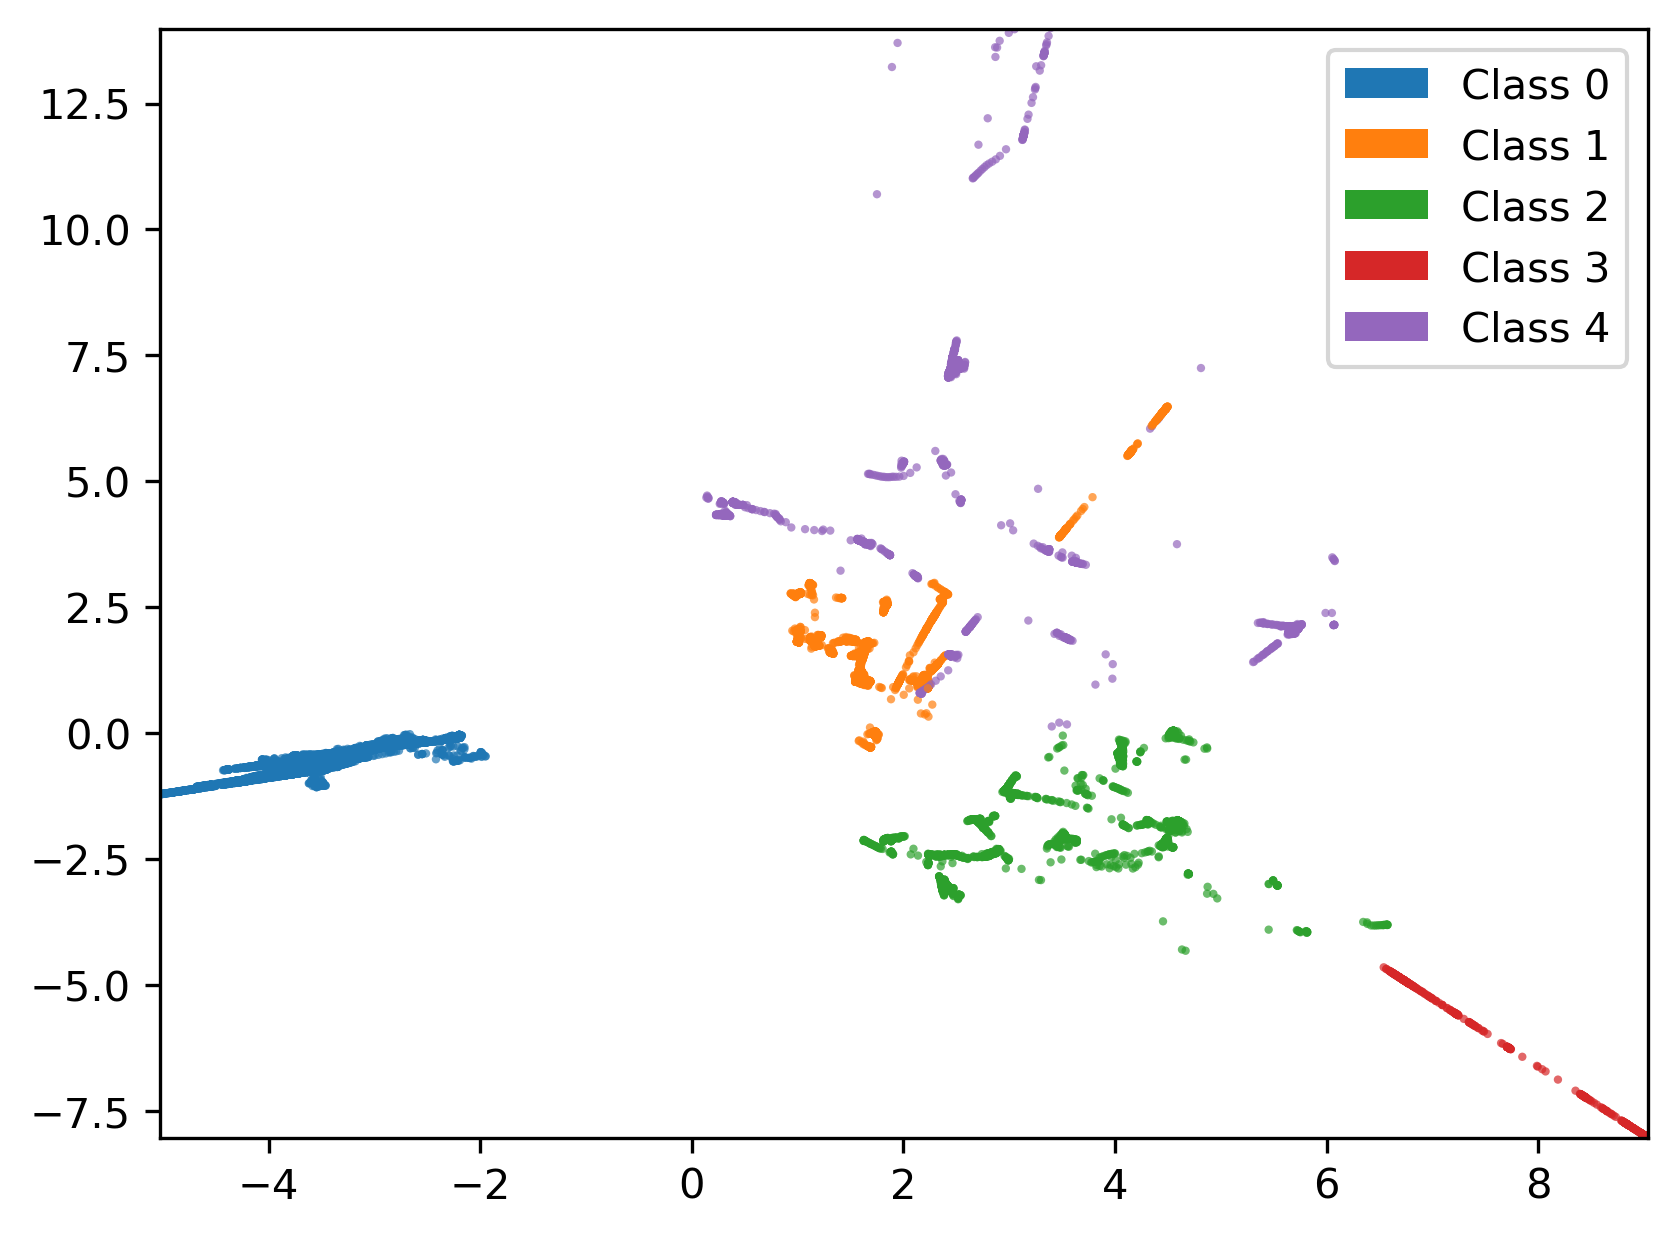

In [63]:
plt.figure(dpi=300)
point_colors = [f"C{i}" for i in kmeans.labels_]
plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    s=4,
    alpha=0.7,
    c=point_colors,
    edgecolors="none",
)
# make legend
legend_elements = [
    plt.matplotlib.patches.Patch(
        facecolor=f"C{i}", edgecolor="none", label=f"Class {i}"
    )
    for i in range(5)
]
plt.legend(handles=legend_elements)
plt.xlim(xlow[0], xhi[0])
plt.ylim(xlow[1], xhi[1])
plt.show()

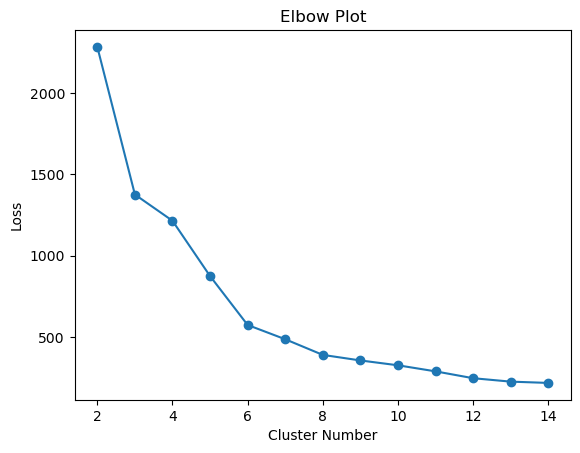

In [65]:
# make an elbow plot
loss = []
cn = range(2, 15)
for i in cn:
    kmeans = sklearn.cluster.KMeans(n_clusters=i, random_state=0)
    # use every 50th point
    kmeans.fit(std_features[::50])
    # we get score -> opposite of loss
    # so take -
    loss.append(-kmeans.score(std_features[::50]))

plt.plot(cn, loss, "o-")
plt.xlabel("Cluster Number")
plt.ylabel("Loss")
plt.title("Elbow Plot")
plt.show()

In [69]:
# extract cluster centers:  cluster - using whole features
kmeans = sklearn.cluster.KMeans(n_clusters=5, random_state=0)
kmeans.fit(std_features)

cluster_center_idx = []
for c in kmeans.cluster_centers_:
    # find point closest
    i = np.argmin(np.sum((std_features - c) ** 2, axis=1))
    cluster_center_idx.append(i)
cluster_centers = nucprop_df.iloc[cluster_center_idx, :]

legend_text = [f"Class {i}" for i in range(5)]

cluster_centers

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,span,skew
11385,rw_cut_5_p1_3f_opt_disp_struct_5.xyz,Nucleus 1H :,0.981399,-0.024373,-1.324554,29.02,35.35,23.38,28.32,41.03,25.86,31.60,-6.80,-0.84,-3.79,23.38,28.32,35.35,11.97,-0.18
13006,rw_cut_5_p1_opt_disp_struct_0.xyz,Nucleus 9C :,1.458411,-5.488221,0.525948,53.35,178.51,31.62,-50.07,250.76,275.88,264.76,-72.65,-241.22,-317.46,-50.07,31.62,178.51,228.58,-0.29
2670,dw_cut_4_n1_ch3_opt.xyz,Nucleus 22C :,0.118965,-2.917258,3.092278,157.02,120.26,194.03,156.78,256.56,232.53,231.68,-111.82,-58.02,-79.86,120.26,156.78,194.03,73.77,-0.01
2304,dw_cut_4_n1_4f_opt_disp_struct_14.xyz,Nucleus 10F :,3.659159,-4.724531,1.680903,330.77,444.23,262.41,285.66,481.46,464.85,459.70,-20.48,-202.89,-190.34,262.41,285.66,444.23,181.82,-0.74
4305,n_cut_0_0_opt.xyz,Nucleus 3C :,-1.346844,2.474902,-0.577091,6.58,-88.58,14.05,94.26,222.81,256.77,262.41,-346.27,-247.35,-128.64,-88.58,14.05,94.26,182.84,0.12


## Deep Learning

In [72]:
import tensorflow as tf

In [74]:
# standardize the features
nucprop_df[feature_names] -= nucprop_df[feature_names].mean()
nucprop_df[feature_names] /= nucprop_df[feature_names].std()

In [107]:
full_data = tf.data.Dataset.from_tensor_slices(
    (nucprop_df[feature_names].values, nucprop_df["sigma_iso"].values)
)
N = len(nucprop_df)
test_N = int(0.2*N)
test_data = full_data.take(test_N).batch(16)
train_data = full_data.skip(test_N).batch(16)

In [109]:
# our hidden layer
# We only need to define the output dimension - 32.
hidden_layer = tf.keras.layers.Dense(32, activation="tanh")
# Last layer - which we want to output one number
# the predicted solubility.
output_layer = tf.keras.layers.Dense(1)

# Now we put the layers into a sequential model
model = tf.keras.Sequential()
model.add(hidden_layer)
model.add(output_layer)

# our model is complete

# Try out our model on first few datapoints
model(nucprop_df[feature_names].values[:3])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.3534101],
       [1.3983572],
       [1.3780885]], dtype=float32)>

In [111]:
model.compile(optimizer="SGD", loss="mean_squared_error")

In [113]:
model.fit(train_data, epochs=50)

Epoch 1/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - loss: 0.1004
Epoch 2/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 148us/step - loss: 0.0060
Epoch 3/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - loss: 0.0033
Epoch 4/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - loss: 0.0025
Epoch 5/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - loss: 0.0020
Epoch 6/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - loss: 0.0018
Epoch 7/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - loss: 0.0016
Epoch 8/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - loss: 0.0014
Epoch 9/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - loss: 0.0013
Epoch 10/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 145us/step - loss: 0.0012
Epoch 11/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - loss: 0.0011
Epoch 12/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - loss: 0.0010
Epoch 13/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - loss: 9.4181e-04
Epoch 14/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - loss: 8.7865e-04
Epoch 15/50
719/719 ━

In [115]:
# get model predictions on test data and get labels
# squeeze to remove extra dimensions
yhat = np.squeeze(model.predict(test_data))
test_y = nucprop_df["sigma_iso"].values[:test_N]

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
/var/folders/s_/t420f2pn6xq2bv06qkv7bdp40000gn/T/ipykernel_26280/2206297110.py:4: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Predicted sigma_iso $\hat{y}$")


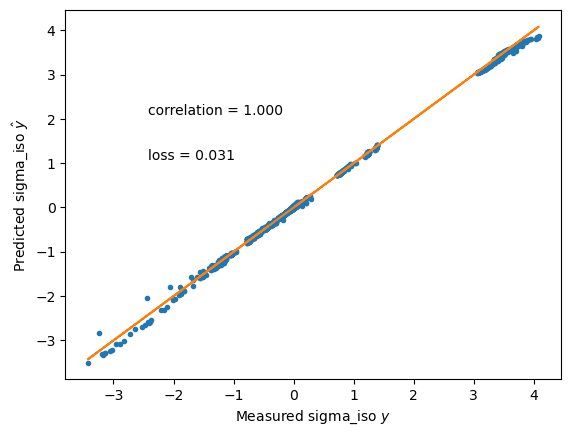

In [117]:
plt.plot(test_y, yhat, ".")
plt.plot(test_y, test_y, "-")
plt.xlabel("Measured sigma_iso $y$")
plt.ylabel("Predicted sigma_iso $\hat{y}$")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.show()

### Graph neural networks

In [93]:
pos_data, neg_data = nucprop_df["positives"], nucprop_df["negatives"]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(16)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

KeyError: 'positives'